In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5334, done.
remote: Counting objects: 100% (523/523), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 5334 (delta 440), reused 505 (delta 424), pack-reused 4811
Receiving objects: 100% (5334/5334), 2.87 GiB | 28.29 MiB/s, done.
Resolving deltas: 100% (4266/4266), done.
Updating files: 100% (475/475), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 11.3 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 10.3 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker, XGBClassifier

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/sli

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 50,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

'/kaggle/working/slim_recall_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1045.19 column/sec. Elapsed time 21.38 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 684.32 column/sec. Elapsed time 19.03 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2561.52 column/sec. Elapsed time 8.72 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [26]:
print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 11.27 sec. Users per second: 928


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081207,0.139076,0.117361,0.039491,0.06875,0.237151,0.127435,0.095993,0.47523,0.303409,...,0.802826,0.381526,0.802826,0.090972,10.726299,0.998441,0.266038,0.82708,1.500923,0.387352


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 9.00 sec. Users per second: 1162


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079141,0.134235,0.112828,0.038628,0.066894,0.232462,0.124094,0.093029,0.464327,0.297299,...,0.802826,0.372773,0.802826,0.075712,10.418373,0.997966,0.221413,0.803337,1.652023,0.383676


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 9.26 sec. Users per second: 1129


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 8.72 sec. Users per second: 1199


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.23 sec. Users per second: 855


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061477,0.112346,0.096871,0.028592,0.05208,0.191056,0.099645,0.075218,0.406848,0.232673,...,0.802826,0.326628,0.802826,0.011358,7.735149,0.986167,0.033216,0.59644,3.662361,0.323459


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 11.43 sec. Users per second: 915


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.61 sec. Users per second: 986


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 13.05 sec. Users per second: 801


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 14.02 sec. Users per second: 746


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 10.33 sec. Users per second: 1012


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.28 sec. Users per second: 851


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 13.60 sec. Users per second: 769


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07523,0.130395,0.110728,0.036193,0.063731,0.2264,0.119463,0.089591,0.46031,0.284432,...,0.802826,0.369549,0.802826,0.030039,9.477048,0.99708,0.087846,0.730753,2.146813,0.353406


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 14.44 sec. Users per second: 724


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


In [27]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [28]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [29]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [30]:
training_dataframe.Label.sum()

15808

In [31]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [32]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [34]:
tmp.ItemID.values.astype(int)

array([  35,  100,  505,  428,  591,  693,  402, 1480,  122,  617,  976,
        868,    3,  514,  111,    2,  636, 1545,  256,  341,  336, 1629,
        101,    9,   84,    1,    0, 1421,  849, 1287, 1934, 1082, 1213,
         53,   28,  288, 1056,   57,   76,   75,  921,   86, 1337, 2498,
        772,  136,  283,  533,   97,  155])

In [35]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([    0,     1,     2,    12,     3,     4,     6,     5,     9,
           7,    48,  8148,  7493,    26,    50,  7492,    39,    11,
        7687,     8,  7637,    29,    27,  7498,  7527,  7491, 21981,
          10,    43,    14,    41,    13,    16,  7540,  7473,  7589,
          23,  7544,  7519,    34,    60,  7529,    15,  6456,    33,
        7423,  7584,  7087,  7410,    45])

In [36]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [37]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,EaseR_RankPosition,EaseR_Recommended,IALS_Score,IALS_RankPosition,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.0,1.0,0.417650,1.0,1.0,11,1.833333,4.549392,3.243913,10.813503
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,1.0,1.0,0.495697,0.0,1.0,12,0.583333,0.514929,-0.388403,-2.262857
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,2.0,1.0,0.363251,2.0,1.0,12,2.750000,1.356801,1.850759,2.463893
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,3.0,1.0,0.258930,4.0,1.0,5,18.166667,18.210054,1.294699,0.844016
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,5.0,1.0,0.173614,19.0,0.0,6,57.416667,128.683868,3.236769,10.794514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,44.0,0.0,0.135079,134.0,0.0,2,55.583333,41.306963,0.694051,0.073197
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,130.0,0.0,0.313277,14.0,0.0,3,52.583333,43.160290,0.399351,-1.101373
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,38.0,0.0,0.240429,36.0,0.0,1,283.583333,466.950349,2.764785,8.336565
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,26.0,0.0,0.257621,30.0,0.0,0,1380.166667,3092.025545,2.055036,2.641748


In [38]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,1.0,11,1.833333,4.549392,3.243913,10.813503,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,1.0,12,0.583333,0.514929,-0.388403,-2.262857,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,1.0,12,2.750000,1.356801,1.850759,2.463893,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,1.0,5,18.166667,18.210054,1.294699,0.844016,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,0.0,6,57.416667,128.683868,3.236769,10.794514,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,0.0,2,55.583333,41.306963,0.694051,0.073197,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.0,3,52.583333,43.160290,0.399351,-1.101373,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,0.0,1,283.583333,466.950349,2.764785,8.336565,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,0.0,0,1380.166667,3092.025545,2.055036,2.641748,0.047915,0.055156,53.265190,112.935230


In [39]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,43.0,0.0,0.047095,46.0,0.0,0.063939,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,41.0,0.0,0.031756,125.0,0.0,0.061394,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,106.0,0.0,0.059093,621.0,0.0,0.086976,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,48.0,0.0,0.219686,48.0,0.0,0.049547,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,53.0,0.0,0.026436,2196.0,0.0,0.096624,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,30.0,0.0,0.353050,8.0,1.0,0.167004,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [40]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "logistic"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBClassifier(
    objective='binary:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    enable_categorical = True
)

In [41]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    verbose=True
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=32,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

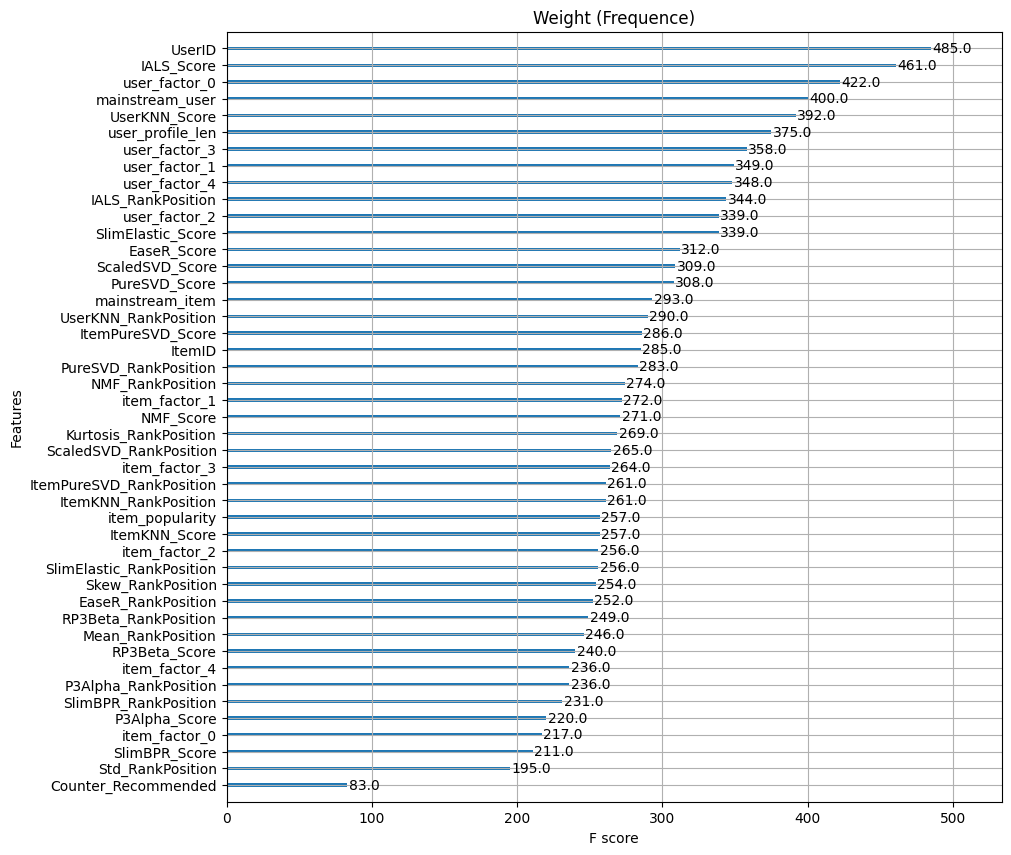

In [42]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [43]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1134.49 column/sec. Elapsed time 19.70 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 673.30 column/sec. Elapsed time 19.34 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2467.00 column/sec. Elapsed time 9.06 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [44]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [45]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_19/907138705.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,IALS_Score,IALS_RankPosition,IALS_Recommended,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.514264,1.0,1.0,10,2.000000,4.242641,2.065609,2.885410,0.406406,0.032075
1,0,100,0.830547,1.0,1.0,0.296112,1.0,1.0,0.744487,1.0,...,0.621994,0.0,1.0,12,0.750000,0.452267,-1.326650,-0.325926,0.237011,0.032075
2,0,505,0.471617,3.0,1.0,0.135064,4.0,1.0,0.288312,3.0,...,0.371543,3.0,1.0,12,4.333333,2.386833,1.066133,-0.242010,0.074733,0.032075
3,0,51,0.213902,19.0,0.0,0.042878,115.0,0.0,0.111361,14.0,...,0.177052,23.0,0.0,6,17.750000,31.623136,3.093531,10.117649,0.202135,0.032075
4,0,402,0.598366,2.0,1.0,0.122285,5.0,1.0,0.283639,4.0,...,0.426898,2.0,1.0,9,7.083333,7.913835,2.286606,5.458151,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,59.0,0.0,0.059399,687.0,0.0,0.057316,77.0,...,0.307450,25.0,0.0,2,98.666667,188.834383,3.245945,10.847786,0.113879,0.056604
651196,13023,852,0.056650,89.0,0.0,0.338165,19.0,0.0,0.000000,8068.0,...,0.274723,39.0,0.0,0,1392.500000,3127.692338,2.054632,2.638664,0.054093,0.056604
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.339215,19.0,0.0,0,813.250000,2373.983615,3.421945,11.778180,0.054804,0.056604
651198,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.227916,65.0,0.0,0,235.083333,415.592339,2.397963,5.376126,0.004982,0.056604


In [46]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,7509.0,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,21.0,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,7480.0,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,8.0,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,16.0,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [47]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [48]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict_proba(df_slice)[:, 1]
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [49]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 2.99 min. Users per second: 58


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.095457,0.165837,0.14077,0.047809,0.081024,0.268057,0.148861,0.113768,0.525631,0.35422,...,0.802826,0.42199,0.802826,0.048779,10.054131,0.997402,0.140746,0.774531,1.962574,0.293568


In [50]:
def objective_xgboost(trial):

    XGB_model = XGBClassifier(
        objective = 'binary:logistic',
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [51]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost_classifier.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [52]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_fixed_more_features', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-21 09:02:47,072] Using an existing study with name 'xgboost_tuning_fixed_more_features' instead of creating a new one.


EvaluatorHoldout: Processed 10000 (95.6%) in 5.15 min. Users per second: 32
EvaluatorHoldout: Processed 10456 (100.0%) in 5.37 min. Users per second: 32


[I 2023-12-21 09:14:33,011] Trial 150 finished with value: 0.04938766076438268 and parameters: {'n_estimators': 1643, 'learning_rate': 0.007312340439174714, 'reg_alpha': 0.004446599993042399, 'reg_lambda': 0.03568530895051034, 'max_depth': 12, 'max_leaves': 382, 'grow_policy': 'depthwise', 'gamma': 0.3877174021387698, 'min_child_weight': 0.0019017447550931249, 'subsample': 0.3985540213801678, 'colsample_bytree': 0.8646014549175461}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.46 min. Users per second: 50


[I 2023-12-21 09:21:45,178] Trial 151 finished with value: 0.05173484351659618 and parameters: {'n_estimators': 2215, 'learning_rate': 0.004731481281756983, 'reg_alpha': 0.007585961140521744, 'reg_lambda': 0.019149545880425656, 'max_depth': 4, 'max_leaves': 477, 'grow_policy': 'depthwise', 'gamma': 1.2038159038537628, 'min_child_weight': 0.4690299030762424, 'subsample': 0.3560449185941774, 'colsample_bytree': 0.8809161419619442}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.70 min. Users per second: 47


[I 2023-12-21 09:30:51,108] Trial 152 finished with value: 0.05171877087356286 and parameters: {'n_estimators': 3204, 'learning_rate': 0.0032583818037707998, 'reg_alpha': 0.0030624729258709026, 'reg_lambda': 0.023104679636422622, 'max_depth': 4, 'max_leaves': 440, 'grow_policy': 'depthwise', 'gamma': 0.973849127763307, 'min_child_weight': 0.28550677179531686, 'subsample': 0.3733783295633869, 'colsample_bytree': 0.8588155152899986}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.72 min. Users per second: 47


[I 2023-12-21 09:38:47,429] Trial 153 finished with value: 0.05167462518672404 and parameters: {'n_estimators': 2244, 'learning_rate': 0.005991496744520396, 'reg_alpha': 0.0036150277446674126, 'reg_lambda': 0.00892121980577383, 'max_depth': 5, 'max_leaves': 363, 'grow_policy': 'depthwise', 'gamma': 0.2662002121402801, 'min_child_weight': 0.5619091949686511, 'subsample': 0.3615185261666024, 'colsample_bytree': 0.8850765278635934}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.50 min. Users per second: 50


[I 2023-12-21 09:45:53,859] Trial 154 finished with value: 0.051876305546447704 and parameters: {'n_estimators': 1856, 'learning_rate': 0.004437409421764486, 'reg_alpha': 0.004272356205301609, 'reg_lambda': 0.01628403001950723, 'max_depth': 5, 'max_leaves': 426, 'grow_policy': 'depthwise', 'gamma': 1.8372209051533517, 'min_child_weight': 0.35689947426072494, 'subsample': 0.3891684486048508, 'colsample_bytree': 0.8300552431349477}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.08 min. Users per second: 30
EvaluatorHoldout: Processed 10456 (100.0%) in 5.89 min. Users per second: 30


[I 2023-12-21 09:59:11,076] Trial 155 finished with value: 0.049638822852528346 and parameters: {'n_estimators': 1842, 'learning_rate': 0.004510753659803543, 'reg_alpha': 0.0055980734654968705, 'reg_lambda': 0.016244602688040843, 'max_depth': 20, 'max_leaves': 469, 'grow_policy': 'depthwise', 'gamma': 1.68630479263116, 'min_child_weight': 0.2269976557313955, 'subsample': 0.38751494649695895, 'colsample_bytree': 0.8300390452884896}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.31 min. Users per second: 53


[I 2023-12-21 10:05:14,509] Trial 156 finished with value: 0.05157107713654252 and parameters: {'n_estimators': 1570, 'learning_rate': 0.005326967611817365, 'reg_alpha': 0.010066961337304834, 'reg_lambda': 0.019892541682420706, 'max_depth': 4, 'max_leaves': 392, 'grow_policy': 'depthwise', 'gamma': 0.6719568436004334, 'min_child_weight': 0.15064013913051355, 'subsample': 0.412284744798068, 'colsample_bytree': 0.84843443867712}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.59 min. Users per second: 49


[I 2023-12-21 10:12:57,219] Trial 157 finished with value: 0.05174067293329021 and parameters: {'n_estimators': 2077, 'learning_rate': 0.0034903584866601374, 'reg_alpha': 0.004252716362100073, 'reg_lambda': 0.026135370627228195, 'max_depth': 5, 'max_leaves': 440, 'grow_policy': 'depthwise', 'gamma': 2.149551767176998, 'min_child_weight': 0.39522586230585005, 'subsample': 0.42329150185385145, 'colsample_bytree': 0.8688165427772534}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.52 min. Users per second: 50


[I 2023-12-21 10:20:33,509] Trial 158 finished with value: 0.05190484919420513 and parameters: {'n_estimators': 2464, 'learning_rate': 0.004377665447299905, 'reg_alpha': 0.00288010783630953, 'reg_lambda': 0.012685522786616952, 'max_depth': 4, 'max_leaves': 420, 'grow_policy': 'depthwise', 'gamma': 1.273184262736746, 'min_child_weight': 0.335729435675489, 'subsample': 0.3374215625265764, 'colsample_bytree': 0.8923516803474904}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.27 min. Users per second: 53


[I 2023-12-21 10:27:22,630] Trial 159 finished with value: 0.051621249590119704 and parameters: {'n_estimators': 2503, 'learning_rate': 0.008144087512744811, 'reg_alpha': 0.003138917767601948, 'reg_lambda': 0.01133523981573216, 'max_depth': 3, 'max_leaves': 423, 'grow_policy': 'depthwise', 'gamma': 1.3198674101383694, 'min_child_weight': 0.3257391359803257, 'subsample': 0.3348623045207828, 'colsample_bytree': 0.8914070881342909}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.43 min. Users per second: 51


[I 2023-12-21 10:33:54,529] Trial 160 finished with value: 0.051502152633561095 and parameters: {'n_estimators': 1879, 'learning_rate': 0.007017367760289179, 'reg_alpha': 0.004020969993422927, 'reg_lambda': 0.006397784518066669, 'max_depth': 4, 'max_leaves': 349, 'grow_policy': 'depthwise', 'gamma': 0.9683715964072315, 'min_child_weight': 0.037821012024228745, 'subsample': 0.34339678079994534, 'colsample_bytree': 0.8982668626001301}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.72 min. Users per second: 47


[I 2023-12-21 10:42:22,278] Trial 161 finished with value: 0.05183203082304127 and parameters: {'n_estimators': 2859, 'learning_rate': 0.0043887975708534225, 'reg_alpha': 0.0020358957666418826, 'reg_lambda': 0.013928507072848907, 'max_depth': 4, 'max_leaves': 399, 'grow_policy': 'depthwise', 'gamma': 2.8840244499286434, 'min_child_weight': 0.6514917955765004, 'subsample': 0.39930499453024876, 'colsample_bytree': 0.8626133448641401}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.68 min. Users per second: 47


[I 2023-12-21 10:50:08,909] Trial 162 finished with value: 0.0516878742060461 and parameters: {'n_estimators': 2338, 'learning_rate': 0.003954277945789756, 'reg_alpha': 0.002127628952608259, 'reg_lambda': 0.012978550673636244, 'max_depth': 4, 'max_leaves': 406, 'grow_policy': 'depthwise', 'gamma': 2.5244462480312344, 'min_child_weight': 0.6699020929749252, 'subsample': 0.39451122137803085, 'colsample_bytree': 0.8660505216424584}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.43 min. Users per second: 51


[I 2023-12-21 10:58:03,789] Trial 163 finished with value: 0.050929040514446584 and parameters: {'n_estimators': 3005, 'learning_rate': 0.0031501421232862977, 'reg_alpha': 0.0028470068719931006, 'reg_lambda': 0.008896153763177823, 'max_depth': 3, 'max_leaves': 369, 'grow_policy': 'depthwise', 'gamma': 0.34474751070113124, 'min_child_weight': 0.25648145555170165, 'subsample': 0.37430558872562625, 'colsample_bytree': 0.8452666612356177}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.68 min. Users per second: 47


[I 2023-12-21 11:06:20,603] Trial 164 finished with value: 0.051891588789303555 and parameters: {'n_estimators': 2824, 'learning_rate': 0.005610081873283951, 'reg_alpha': 0.0067844353126081825, 'reg_lambda': 0.015046190975093474, 'max_depth': 4, 'max_leaves': 435, 'grow_policy': 'depthwise', 'gamma': 1.747591403404874, 'min_child_weight': 0.6248779131541591, 'subsample': 0.35128806365795684, 'colsample_bytree': 0.8786714995941259}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 7000 (66.9%) in 5.59 min. Users per second: 21
EvaluatorHoldout: Processed 10456 (100.0%) in 8.31 min. Users per second: 21


[I 2023-12-21 11:25:44,723] Trial 165 finished with value: 0.04762632300433624 and parameters: {'n_estimators': 2789, 'learning_rate': 0.006212294248470196, 'reg_alpha': 0.0068884358733421, 'reg_lambda': 0.010435524060804533, 'max_depth': 14, 'max_leaves': 398, 'grow_policy': 'depthwise', 'gamma': 1.7954235870441333, 'min_child_weight': 0.708630635823795, 'subsample': 0.35340206137283803, 'colsample_bytree': 0.8633399081236446}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.82 min. Users per second: 46


[I 2023-12-21 11:35:19,754] Trial 166 finished with value: 0.05177591130178219 and parameters: {'n_estimators': 3553, 'learning_rate': 0.0041821879013588, 'reg_alpha': 0.0017040017616080812, 'reg_lambda': 0.01387653848098563, 'max_depth': 4, 'max_leaves': 434, 'grow_policy': 'depthwise', 'gamma': 3.0155486391370467, 'min_child_weight': 0.566938624037455, 'subsample': 0.32669548985226493, 'colsample_bytree': 0.8245344950910837}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.98 min. Users per second: 59


[I 2023-12-21 11:38:45,999] Trial 167 finished with value: 0.04925915172878691 and parameters: {'n_estimators': 206, 'learning_rate': 0.0027865804472885724, 'reg_alpha': 0.0024158887860774602, 'reg_lambda': 0.007815735332536261, 'max_depth': 5, 'max_leaves': 466, 'grow_policy': 'depthwise', 'gamma': 0.5434755561521252, 'min_child_weight': 0.976924087276246, 'subsample': 0.3572227556194376, 'colsample_bytree': 0.8421819229425427}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.29 min. Users per second: 53


[I 2023-12-21 11:45:39,601] Trial 168 finished with value: 0.05124319142347133 and parameters: {'n_estimators': 2535, 'learning_rate': 0.005405098225594525, 'reg_alpha': 0.008348665950158549, 'reg_lambda': 0.01611357404535588, 'max_depth': 3, 'max_leaves': 529, 'grow_policy': 'depthwise', 'gamma': 4.3993063672051145, 'min_child_weight': 0.35478326742957533, 'subsample': 0.310446026388043, 'colsample_bytree': 0.8774088238453243}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2023-12-21 11:55:04,152] Trial 169 finished with value: 0.05178445807677875 and parameters: {'n_estimators': 2929, 'learning_rate': 0.003546365459459978, 'reg_alpha': 0.0033830535730203144, 'reg_lambda': 0.012053206161316258, 'max_depth': 5, 'max_leaves': 499, 'grow_policy': 'depthwise', 'gamma': 2.1583430881294614, 'min_child_weight': 0.532300019071193, 'subsample': 0.33617879286195124, 'colsample_bytree': 0.8275562355101542}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.79 min. Users per second: 46


[I 2023-12-21 12:03:10,774] Trial 170 finished with value: 0.051824311400153644 and parameters: {'n_estimators': 2266, 'learning_rate': 0.004346494628022139, 'reg_alpha': 0.0017627719175627517, 'reg_lambda': 0.020571837953791187, 'max_depth': 5, 'max_leaves': 382, 'grow_policy': 'depthwise', 'gamma': 0.00031191191869822167, 'min_child_weight': 0.007564713740574968, 'subsample': 0.38236957503200847, 'colsample_bytree': 0.8538864924763128}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.53 min. Users per second: 49


[I 2023-12-21 12:10:14,928] Trial 171 finished with value: 0.0516220200143313 and parameters: {'n_estimators': 2058, 'learning_rate': 0.005192768615823827, 'reg_alpha': 0.004696956603762282, 'reg_lambda': 0.029476675900891272, 'max_depth': 4, 'max_leaves': 430, 'grow_policy': 'depthwise', 'gamma': 1.0761816933756039, 'min_child_weight': 0.206533086997948, 'subsample': 0.40475140788964303, 'colsample_bytree': 0.8958395051297943}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.05 min. Users per second: 57


[I 2023-12-21 12:14:04,549] Trial 172 finished with value: 0.04946092317314645 and parameters: {'n_estimators': 379, 'learning_rate': 0.005165302584182787, 'reg_alpha': 0.005206537067620083, 'reg_lambda': 0.01473275164332224, 'max_depth': 4, 'max_leaves': 452, 'grow_policy': 'depthwise', 'gamma': 1.3348182119836702, 'min_child_weight': 0.31800717220157126, 'subsample': 0.37140208919604284, 'colsample_bytree': 0.880573503549587}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.64 min. Users per second: 48


[I 2023-12-21 12:22:02,624] Trial 173 finished with value: 0.051675520852309836 and parameters: {'n_estimators': 2682, 'learning_rate': 0.006158197043547104, 'reg_alpha': 0.0064685227344984855, 'reg_lambda': 0.022916935493507984, 'max_depth': 4, 'max_leaves': 416, 'grow_policy': 'depthwise', 'gamma': 3.23568688576664, 'min_child_weight': 3.10416847766048e-05, 'subsample': 0.3544954668075321, 'colsample_bytree': 0.8656136192162506}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.56 min. Users per second: 49


[I 2023-12-21 12:29:08,177] Trial 174 finished with value: 0.05143960025989544 and parameters: {'n_estimators': 1709, 'learning_rate': 0.0034203432116411557, 'reg_alpha': 0.002244452267938679, 'reg_lambda': 0.010015347329031065, 'max_depth': 5, 'max_leaves': 264, 'grow_policy': 'depthwise', 'gamma': 0.7472060070475305, 'min_child_weight': 0.1447197836551537, 'subsample': 0.3824411178358624, 'colsample_bytree': 0.8143127014283487}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.39 min. Users per second: 51


[I 2023-12-21 12:37:05,416] Trial 175 finished with value: 0.05128872235581354 and parameters: {'n_estimators': 3198, 'learning_rate': 0.004553562766822388, 'reg_alpha': 0.0036544041060681647, 'reg_lambda': 0.018546999142568455, 'max_depth': 3, 'max_leaves': 354, 'grow_policy': 'depthwise', 'gamma': 1.5656924226622422, 'min_child_weight': 0.7073004992585924, 'subsample': 0.4061798410172837, 'colsample_bytree': 0.8483930459839206}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.39 min. Users per second: 51


[I 2023-12-21 12:44:24,806] Trial 176 finished with value: 0.051332545451233856 and parameters: {'n_estimators': 2222, 'learning_rate': 0.003035807002196519, 'reg_alpha': 0.002809413086400483, 'reg_lambda': 0.03539503006074458, 'max_depth': 4, 'max_leaves': 331, 'grow_policy': 'depthwise', 'gamma': 3.9346212849585585, 'min_child_weight': 0.42105899922108525, 'subsample': 0.32712670785909764, 'colsample_bytree': 0.8335680853767901}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.17 min. Users per second: 55


[I 2023-12-21 12:49:51,662] Trial 177 finished with value: 0.05000567001858175 and parameters: {'n_estimators': 1186, 'learning_rate': 0.002358882491181137, 'reg_alpha': 0.01090922333792486, 'reg_lambda': 0.012525979596593111, 'max_depth': 4, 'max_leaves': 377, 'grow_policy': 'depthwise', 'gamma': 2.4318163067358083, 'min_child_weight': 0.2519391840340948, 'subsample': 0.39560453455583733, 'colsample_bytree': 0.87673984191616}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.25 min. Users per second: 41


[I 2023-12-21 13:01:06,416] Trial 178 finished with value: 0.051112458404683384 and parameters: {'n_estimators': 3968, 'learning_rate': 0.007283471530386878, 'reg_alpha': 0.0047355228087857144, 'reg_lambda': 0.0056969236927766845, 'max_depth': 5, 'max_leaves': 421, 'grow_policy': 'depthwise', 'gamma': 0.9054394391059897, 'min_child_weight': 0.5203235364471716, 'subsample': 0.3446671835582203, 'colsample_bytree': 0.5800456676617132}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.26 min. Users per second: 53


[I 2023-12-21 13:07:05,223] Trial 179 finished with value: 0.05140443020488036 and parameters: {'n_estimators': 1371, 'learning_rate': 0.003793326516468962, 'reg_alpha': 0.002913149828883044, 'reg_lambda': 0.02496413421183741, 'max_depth': 5, 'max_leaves': 454, 'grow_policy': 'depthwise', 'gamma': 9.971463074445944, 'min_child_weight': 0.3405414457322187, 'subsample': 0.3649565173764047, 'colsample_bytree': 0.8875954726004677}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.16 min. Users per second: 42


[I 2023-12-21 13:16:31,033] Trial 180 finished with value: 0.05147388983009715 and parameters: {'n_estimators': 2548, 'learning_rate': 0.004822804752391791, 'reg_alpha': 0.0016420427756444894, 'reg_lambda': 0.008335990613095753, 'max_depth': 6, 'max_leaves': 395, 'grow_policy': 'depthwise', 'gamma': 1.6523156930243297, 'min_child_weight': 0.9948990735923472, 'subsample': 0.4214355829471409, 'colsample_bytree': 0.8148938883770912}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.11 min. Users per second: 42


[I 2023-12-21 13:27:07,210] Trial 181 finished with value: 0.05154977471733444 and parameters: {'n_estimators': 3672, 'learning_rate': 0.004464142715965907, 'reg_alpha': 0.0021953678576288925, 'reg_lambda': 0.016898385391109022, 'max_depth': 5, 'max_leaves': 489, 'grow_policy': 'depthwise', 'gamma': 4.817478810021403, 'min_child_weight': 0.470675115601741, 'subsample': 0.3831541396862443, 'colsample_bytree': 0.6672848390510717}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.24 min. Users per second: 41


[I 2023-12-21 13:38:22,863] Trial 182 finished with value: 0.051237282307720636 and parameters: {'n_estimators': 4334, 'learning_rate': 0.006079994809538322, 'reg_alpha': 0.0013052013864580107, 'reg_lambda': 0.019557800201051, 'max_depth': 5, 'max_leaves': 393, 'grow_policy': 'depthwise', 'gamma': 5.743132232284042, 'min_child_weight': 0.667471967491508, 'subsample': 0.4434097594709102, 'colsample_bytree': 0.8977607878853668}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.87 min. Users per second: 61


[I 2023-12-21 13:41:26,973] Trial 183 finished with value: 0.04798570502544356 and parameters: {'n_estimators': 89, 'learning_rate': 0.004058715448001773, 'reg_alpha': 0.0038984645825516405, 'reg_lambda': 0.015522359011520364, 'max_depth': 4, 'max_leaves': 414, 'grow_policy': 'depthwise', 'gamma': 3.1450489368420547, 'min_child_weight': 0.19424877325050374, 'subsample': 0.43360536963465474, 'colsample_bytree': 0.6231375876436415}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.58 min. Users per second: 38


[I 2023-12-21 13:54:39,857] Trial 184 finished with value: 0.05164986155135411 and parameters: {'n_estimators': 4988, 'learning_rate': 0.002772839055207002, 'reg_alpha': 0.005876196874287587, 'reg_lambda': 0.010778372053042367, 'max_depth': 5, 'max_leaves': 33, 'grow_policy': 'depthwise', 'gamma': 6.359607663604608, 'min_child_weight': 0.017042749827764596, 'subsample': 0.3994328135198909, 'colsample_bytree': 0.7948763015309688}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.57 min. Users per second: 38


[I 2023-12-21 14:05:31,597] Trial 185 finished with value: 0.051593905223400724 and parameters: {'n_estimators': 2943, 'learning_rate': 0.0034879437225861032, 'reg_alpha': 0.002058732612746763, 'reg_lambda': 0.014177822826823465, 'max_depth': 6, 'max_leaves': 362, 'grow_policy': 'depthwise', 'gamma': 2.3784325344140074, 'min_child_weight': 0.36892813353302, 'subsample': 0.3606475827124982, 'colsample_bytree': 0.8562897605635598}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.62 min. Users per second: 48


[I 2023-12-21 14:14:00,170] Trial 186 finished with value: 0.051728198133372844 and parameters: {'n_estimators': 3373, 'learning_rate': 0.005294804584201401, 'reg_alpha': 0.008927937892294235, 'reg_lambda': 0.021455869829759205, 'max_depth': 4, 'max_leaves': 67, 'grow_policy': 'depthwise', 'gamma': 6.983427235295124, 'min_child_weight': 0.7233875091814861, 'subsample': 0.41514926483879433, 'colsample_bytree': 0.4359984526258997}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.74 min. Users per second: 47


[I 2023-12-21 14:21:16,095] Trial 187 finished with value: 0.05125911225877805 and parameters: {'n_estimators': 1920, 'learning_rate': 0.00885834649399278, 'reg_alpha': 0.003288842517533061, 'reg_lambda': 0.01888790355569746, 'max_depth': 5, 'max_leaves': 432, 'grow_policy': 'depthwise', 'gamma': 1.1079975046614559, 'min_child_weight': 0.27119235739210434, 'subsample': 0.30921450523017363, 'colsample_bytree': 0.8348036546524037}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.45 min. Users per second: 51


[I 2023-12-21 14:28:43,039] Trial 188 finished with value: 0.051658579110043 and parameters: {'n_estimators': 2404, 'learning_rate': 0.004376596740968535, 'reg_alpha': 0.0026757578893788, 'reg_lambda': 0.026382157611977083, 'max_depth': 4, 'max_leaves': 308, 'grow_policy': 'depthwise', 'gamma': 3.4915825198432415, 'min_child_weight': 0.4952455693128366, 'subsample': 0.46421098759183793, 'colsample_bytree': 0.8137642054743377}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.37 min. Users per second: 40


[I 2023-12-21 14:40:06,435] Trial 189 finished with value: 0.05101749887662324 and parameters: {'n_estimators': 3958, 'learning_rate': 0.006047090593899472, 'reg_alpha': 0.0011277110994270692, 'reg_lambda': 0.012033169422745685, 'max_depth': 5, 'max_leaves': 87, 'grow_policy': 'depthwise', 'gamma': 0.5707140858517378, 'min_child_weight': 0.1044820125432219, 'subsample': 0.3746922861634887, 'colsample_bytree': 0.8626056018487539}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.33 min. Users per second: 52


[I 2023-12-21 14:47:41,178] Trial 190 finished with value: 0.05098490196257084 and parameters: {'n_estimators': 2944, 'learning_rate': 0.003157135988708716, 'reg_alpha': 0.001438307091969687, 'reg_lambda': 0.009181645825119319, 'max_depth': 3, 'max_leaves': 11, 'grow_policy': 'depthwise', 'gamma': 1.925452937055073, 'min_child_weight': 0.38977781987511195, 'subsample': 0.3419428029653826, 'colsample_bytree': 0.8438184277845481}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.70 min. Users per second: 47


[I 2023-12-21 14:55:33,438] Trial 191 finished with value: 0.05179314147872936 and parameters: {'n_estimators': 2189, 'learning_rate': 0.004403095432984788, 'reg_alpha': 0.0017277851530976588, 'reg_lambda': 0.020064567097580192, 'max_depth': 5, 'max_leaves': 387, 'grow_policy': 'depthwise', 'gamma': 0.0001394692321249954, 'min_child_weight': 0.05025292040812448, 'subsample': 0.3918125464580651, 'colsample_bytree': 0.85133357683593}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2023-12-21 15:04:15,446] Trial 192 finished with value: 0.051775417926671445 and parameters: {'n_estimators': 2279, 'learning_rate': 0.003895158974401798, 'reg_alpha': 0.002035607232206295, 'reg_lambda': 0.01579764937393041, 'max_depth': 6, 'max_leaves': 391, 'grow_policy': 'depthwise', 'gamma': 4.726997057585513, 'min_child_weight': 0.010545053765977712, 'subsample': 0.37876059883861707, 'colsample_bytree': 0.8724798034034255}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.85 min. Users per second: 45


[I 2023-12-21 15:12:49,605] Trial 193 finished with value: 0.05176719374309322 and parameters: {'n_estimators': 2569, 'learning_rate': 0.00489712551676283, 'reg_alpha': 0.0017426501119343592, 'reg_lambda': 0.03253222650621346, 'max_depth': 5, 'max_leaves': 335, 'grow_policy': 'depthwise', 'gamma': 0.013110673426609511, 'min_child_weight': 0.067533296903922, 'subsample': 0.3640100026235257, 'colsample_bytree': 0.8997826144300949}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.35 min. Users per second: 52


[I 2023-12-21 15:19:42,681] Trial 194 finished with value: 0.050784196967489446 and parameters: {'n_estimators': 1884, 'learning_rate': 0.002532780091005873, 'reg_alpha': 0.004035340917279306, 'reg_lambda': 0.024169586177320904, 'max_depth': 4, 'max_leaves': 29, 'grow_policy': 'depthwise', 'gamma': 0.0012183163786169955, 'min_child_weight': 0.5970531850259159, 'subsample': 0.3857646438488936, 'colsample_bytree': 0.5595224518616713}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.17 min. Users per second: 42


[I 2023-12-21 15:29:42,273] Trial 195 finished with value: 0.05106671114633105 and parameters: {'n_estimators': 3299, 'learning_rate': 0.006991566742476782, 'reg_alpha': 0.0024689915033637914, 'reg_lambda': 0.01681253976972404, 'max_depth': 5, 'max_leaves': 452, 'grow_policy': 'depthwise', 'gamma': 0.1761681477524516, 'min_child_weight': 0.18938548340258846, 'subsample': 0.32468780189606705, 'colsample_bytree': 0.8272166124108002}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.66 min. Users per second: 48


[I 2023-12-21 15:37:30,137] Trial 196 finished with value: 0.051671084271505664 and parameters: {'n_estimators': 2087, 'learning_rate': 0.0036480504449502757, 'reg_alpha': 0.0030964000474838827, 'reg_lambda': 0.012381253196350741, 'max_depth': 5, 'max_leaves': 369, 'grow_policy': 'depthwise', 'gamma': 0.00017255346014698406, 'min_child_weight': 0.25214648840126913, 'subsample': 0.42776001457200796, 'colsample_bytree': 0.7896175188916599}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-21 15:45:07,620] Trial 197 finished with value: 0.051401849473531394 and parameters: {'n_estimators': 1667, 'learning_rate': 0.004507858601236192, 'reg_alpha': 0.0009880321541446823, 'reg_lambda': 0.021030390504377036, 'max_depth': 6, 'max_leaves': 407, 'grow_policy': 'depthwise', 'gamma': 1.3843895961244455, 'min_child_weight': 0.006297108975527347, 'subsample': 0.4519383381676445, 'colsample_bytree': 0.8510090027051703}. Best is trial 101 with value: 0.05194072135995486.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.60 min. Users per second: 48


[I 2023-12-21 15:53:08,323] Trial 198 finished with value: 0.051945636135097305 and parameters: {'n_estimators': 2687, 'learning_rate': 0.005471667584983009, 'reg_alpha': 0.0017193571031386306, 'reg_lambda': 0.007105218811703727, 'max_depth': 4, 'max_leaves': 241, 'grow_policy': 'depthwise', 'gamma': 0.09573776346526869, 'min_child_weight': 0.42280974243056085, 'subsample': 0.4053184436750752, 'colsample_bytree': 0.807930575726686}. Best is trial 198 with value: 0.051945636135097305.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.59 min. Users per second: 49


[I 2023-12-21 16:01:09,930] Trial 199 finished with value: 0.05177186183068028 and parameters: {'n_estimators': 2716, 'learning_rate': 0.00530905881344434, 'reg_alpha': 0.0008521622985702196, 'reg_lambda': 0.007057646271766632, 'max_depth': 4, 'max_leaves': 47, 'grow_policy': 'depthwise', 'gamma': 0.04046624913845074, 'min_child_weight': 0.44513536746459076, 'subsample': 0.4095533039270662, 'colsample_bytree': 0.8032285964438336}. Best is trial 198 with value: 0.051945636135097305.


In [53]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [56]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost_classifier.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost_classifier.json', 
            'tuning_results/best_params_hybrid_xgboost_classifier.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost_classifier.json', 
        '/kaggle/working/best_params_hybrid_xgboost_classifier.json'
    )

In [57]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost_classifier.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [58]:
with open('/kaggle/working/best_params_hybrid_xgboost_classifier.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['objective'] = 'binary:logistic'
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'n_estimators': 2687,
 'learning_rate': 0.005471667584983009,
 'reg_alpha': 0.0017193571031386306,
 'reg_lambda': 0.007105218811703727,
 'max_depth': 4,
 'max_leaves': 241,
 'grow_policy': 'depthwise',
 'gamma': 0.09573776346526869,
 'min_child_weight': 0.42280974243056085,
 'subsample': 0.4053184436750752,
 'colsample_bytree': 0.807930575726686,
 'objective': 'binary:logistic',
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [59]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 912.71 column/sec. Elapsed time 24.48 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 615.70 column/sec. Elapsed time 21.15 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2517.22 column/sec. Elapsed time 8.88 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colum

In [60]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [61]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/2498616727.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,...,0.069509,0.012298,0.084060,-0.077164,0.016836,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,86,False,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,...,0.052684,0.052133,0.027592,-0.095366,-0.011944,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,1082,False,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,636,False,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,...,0.009143,0.000777,0.011283,-0.008494,0.002114,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,False,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,...,0.012542,-0.028591,0.021119,0.003770,0.045804,0.009693,-0.007923,-0.000422,0.004503,0.023066
651194,13023,14,False,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,...,0.096477,0.024090,0.105299,-0.131160,0.008674,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,732,False,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651154,13023,324,False,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,...,0.024626,-0.042593,0.041388,0.035765,0.073477,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [62]:
XGB_model = XGBClassifier(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    verbose=True
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.807930575726686, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.09573776346526869,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.005471667584983009,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=241,
              min_child_weight=0.42280974243056085, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2687,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

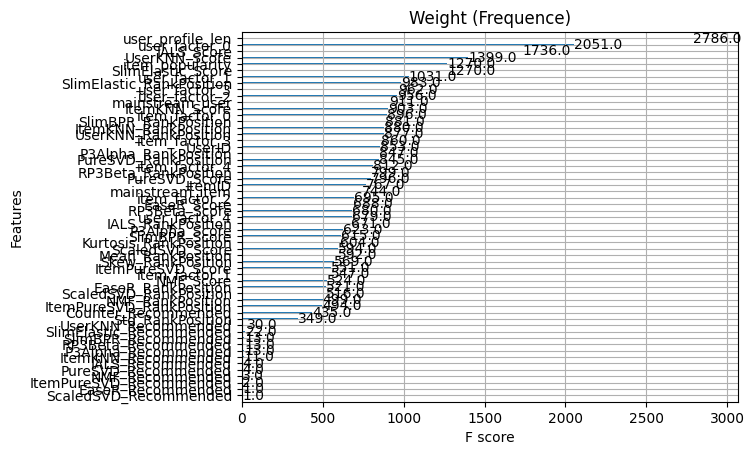

In [63]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [64]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 899.97 column/sec. Elapsed time 24.83 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 541.95 column/sec. Elapsed time 24.03 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2366.53 column/sec. Elapsed time 9.44 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity colum

In [65]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [66]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/446369589.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.0,1.0,0.474078,1.0,1.0,0.786014,1.0,...,0.045669,0.010442,0.052225,-0.058731,0.022079,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,111,0.082615,73.0,0.0,0.121925,11.0,0.0,0.000000,7415.0,...,0.040914,-0.012057,0.014528,-0.047855,-0.023098,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,215,0.180754,23.0,0.0,0.012160,1619.0,0.0,0.085517,21.0,...,0.035591,0.015862,-0.019037,0.043913,0.006133,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,0.235539,18.0,0.0,0.008058,3644.0,0.0,0.064524,39.0,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,58.0,0.0,0.442709,21.0,0.0,0.073992,64.0,...,0.006622,-0.016999,0.013130,0.007500,0.036445,0.009693,-0.007923,-0.000422,0.004503,0.023066
651150,13023,732,0.576149,5.0,1.0,0.711712,0.0,1.0,0.773915,2.0,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651180,13023,685,0.047530,102.0,0.0,0.459579,17.0,0.0,0.000000,7209.0,...,0.010855,-0.026114,0.011748,0.007983,0.029280,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,2119,0.660220,2.0,1.0,0.547857,5.0,1.0,0.593510,6.0,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [67]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [68]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,101 36 506 403 515 123 1546 694 52 977
1,2,1095 12 1522 47 3176 359 949 656 196 102
2,3,59 259 857 584 648 536 239 956 414 9
3,4,249 28 50 5 7 314 139 2 171 146
4,5,1570 5138 77 131 170 471 1511 1220 766 270
